In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("train.csv")

In [3]:
#fill missing values for both train and test dataset
#including cases where missing values appear only in train or only in test
# Columns filled using the neighborhood mode, since these features are not expected to be NaN and have meaningful values
def fill_missing(df):
    """
    Fill missing values for categorical and numerical columns.
    """
    # Categorical columns to fill with "None"
    cat_cols = [
        "Alley","MasVnrType","BsmtQual","BsmtCond","BsmtExposure",
        "BsmtFinType1","BsmtFinType2","FireplaceQu","PoolQC",
        "Fence","MiscFeature","GarageYrBlt","GarageType",
        "GarageQual","GarageCond","GarageFinish",
        "KitchenQual"
    ]

    # Numerical columns to fill with 0
    num_cols = [
        "BsmtHalfBath","BsmtFullBath","GarageArea",
        "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","MasVnrArea"
    ]

    # Fill LotFrontage by median within Neighborhood
    if "LotFrontage" in df.columns:
        df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"]\
                              .transform(lambda x: x.fillna(x.median()))

    # Fill Electrical with mode
    if "Electrical" in df.columns:
        df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])

    # Fill Utilities with mode within Neighborhood
    if "Utilities" in df.columns:
        df["Utilities"] = df.groupby("Neighborhood")["Utilities"]\
                             .transform(lambda x: x.fillna(x.mode()[0]))

    # Fill Exterior1st and Exterior2nd with mode within Neighborhood
    for col in ["Exterior1st", "Exterior2nd"]:
        if col in df.columns:
            df[col] = df.groupby("Neighborhood")[col]\
                        .transform(lambda x: x.fillna(x.mode()[0]))

    # Fill categorical columns with "None"
    df[cat_cols] = df[cat_cols].fillna("None")

    # Fill numerical columns with 0
    df[num_cols] = df[num_cols].fillna(0)

    return df


In [4]:
#Preprocess the columns after filling missing values
# Some columns have ordinal meaning, so we map them to numerical values to preserve their order information
#The rest are one-hot encoded
def preprocess_categorical(df):
    """
    Apply ordinal mappings and one-hot encode nominal columns.
    df : pandas DataFrame
    Returns processed DataFrame.
    """
    # -----------------------------
    # Ordinal / quality mappings
    # -----------------------------
    ordinal_maps = {
        "LotShape": {"Reg":0, "IR1":1, "IR2":2, "IR3":3},
        "LandContour": {"Lvl":0, "Bnk":1, "HLS":2, "Low":3},
        "LandSlope": {"Gtl":0, "Mod":1, "Sev":2},
        "BsmtQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "None":0},
        "ExterQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1},
        "ExterCond": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1},
        "BsmtCond": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "None":0},
        "BsmtExposure": {"Gd":3, "Av":2, "Mn":1, "No":0, "None":0},
        "BsmtFinType1": {"GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, "None":0},
        "BsmtFinType2": {"GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, "None":0},
        "PoolQC": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "None":0},
        "GarageQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "None":0},
        "GarageCond": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "None":0},
        "GarageFinish": {"Fin":3, "RFn":2, "Unf":1, "None":0},
        "FireplaceQu": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "None":0},
        "KitchenQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "None":0},
        "HeatingQC": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "None":0},
        "Fence": {"GdPrv":4, "MnPrv":3, "GdWo":2, "MnWw":1, "None":0},
        "PavedDrive": {"Y":3, "P":2, "N":1}
    }

    for col, mapping in ordinal_maps.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)

    # -----------------------------
    # Nominal columns to one-hot encode
    # -----------------------------
    nominal_cols = [
        "Alley","Neighborhood","Condition1","Condition2","BldgType","HouseStyle",
        "Exterior1st","Exterior2nd","MasVnrType","RoofStyle","RoofMatl",
        "Foundation","GarageType","MiscFeature","SaleType","SaleCondition",
        "Street","MSZoning","LotConfig","Heating","CentralAir","Utilities",
        "Electrical","Functional","GarageYrBlt"
    ]

    # Keep only columns that exist in the DataFrame
    nominal_cols = [col for col in nominal_cols if col in df.columns]
    df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

    return df


In [5]:
df=fill_missing(df)
df=preprocess_categorical(df)

In [6]:
# Create linear dataset for linear model
# Feature engineering: create TotalSF since all square-footage features are highly correlated,
# and the relationship between total area and SalePrice is approximately linear
# drop the combined columns to prevent multicolinearity for linear model
# Choose the top 20 correlated features with SalePrice

lin_dataset = df.copy()
cols_to_drop=["1stFlrSF","2ndFlrSF","TotalBsmtSF","OpenPorchSF","WoodDeckSF"]
lin_dataset["TotalSF"]=lin_dataset["TotalSF"] = (
    lin_dataset["1stFlrSF"]
    + lin_dataset["2ndFlrSF"]
    + lin_dataset["TotalBsmtSF"]
    + lin_dataset["OpenPorchSF"]
    + lin_dataset["WoodDeckSF"]
)
lin_dataset=lin_dataset.drop(cols_to_drop,axis=1)
corr = lin_dataset.corr(numeric_only=True)["SalePrice"].abs()
top_num = corr.sort_values(ascending=False).head(20)
top_features = top_num.index.drop("SalePrice")

lin_X = lin_dataset[top_features]
lin_y = lin_dataset["SalePrice"]

# Split the dataset into training (80%) and testing (20%) sets
X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(
    lin_X, lin_y, test_size=0.2, random_state=42
)


In [7]:
#Drop Garagecars column because it has high correlation with GarageArea
#GarageArea has more meaning, because it shows the actual garage size in square feet
#This dataset will be used for all models except linear regression, since those models do not assume a linear relationship between features and the target.

X = df.drop(columns=["SalePrice","GarageCars"])
y=df["SalePrice"]

#Numerical features are standardized to ensure that all features contribute equally to distance-based and margin-based models such as KNN and SVM.
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["uint8", "bool"]).columns
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", "passthrough", cat_cols)
    ]
)

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
svr_model = Pipeline([
    ("preprocess", preprocess),
    ("model", SVR())
])
knn_model = Pipeline([
    ("preprocess", preprocess),
    ("model", KNeighborsRegressor())
])
rf_model = Pipeline([
    ("model", RandomForestRegressor( 
        random_state=42
    ))
])
lr_model = Pipeline([
    ("model", LinearRegression( 
    ))
])
xg_model = Pipeline([
    ("model", XGBRegressor( 
        random_state=42
    ))
])
lgb_model = Pipeline([
    ("model", LGBMRegressor( 
        random_state=42
    ))
])
gbr_model=Pipeline([
    ("model", GradientBoostingRegressor( 
        random_state=42
    ))
])
svr_model.fit(X_train,y_train)
knn_model.fit(X_train,y_train)
rf_model.fit(X_train,y_train)
xg_model.fit(X_train,y_train)
lgb_model.fit(X_train,y_train)
lr_model.fit(X_lin_train,y_lin_train)
gbr_model.fit(X_train,y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3344
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 144
[LightGBM] [Info] Start training from score 181441.541952


,steps,"[('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1


In [9]:
#Evaluation metric
def evaluate_log_rmse(model, X_test, y_test, name):
    y_pred = model.predict(X_test)

    # Avoid negative predictions (log safety)
    y_pred = np.clip(y_pred, a_min=0, a_max=None)

    rmse_log = np.sqrt(
        mean_squared_error(
            np.log1p(y_test),
            np.log1p(y_pred)
        )
    )

    print(f"{name} Log-RMSE = {rmse_log:.4f}")
evaluate_log_rmse(svr_model, X_test, y_test, "SVR")
evaluate_log_rmse(knn_model, X_test, y_test, "KNN")
evaluate_log_rmse(rf_model, X_test, y_test, "Random Forest")
evaluate_log_rmse(lr_model, X_lin_test, y_test, "Linear Regression")
evaluate_log_rmse(xg_model, X_test, y_test, "Xgboost")
evaluate_log_rmse(lgb_model, X_test, y_test, "Lightgbm")
evaluate_log_rmse(gbr_model, X_test, y_test, "GradientBoosting")

SVR Log-RMSE = 0.4320
KNN Log-RMSE = 0.1881
Random Forest Log-RMSE = 0.1511
Linear Regression Log-RMSE = 0.1847
Xgboost Log-RMSE = 0.1422
Lightgbm Log-RMSE = 0.1480
GradientBoosting Log-RMSE = 0.1437


In [10]:
# --------------------------------------------------
# Model
# --------------------------------------------------
gbr_model = GradientBoostingRegressor(
    random_state=42,
    n_iter_no_change=None,
    validation_fraction=0.1
)

# --------------------------------------------------
# Parameter distributions
# --------------------------------------------------
param_grid = {
    "n_estimators": [300, 500, 700, 1000],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "max_features": ["sqrt", "log2", None]
}

# --------------------------------------------------
# RandomizedSearchCV
# --------------------------------------------------
n_iter_search = 50  # same as XGB, good tradeoff

random_search = RandomizedSearchCV(
    estimator=gbr_model,
    param_distributions=param_grid,
    n_iter=n_iter_search,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# --------------------------------------------------
# Fit
# --------------------------------------------------
random_search.fit(X_train, y_train)

# --------------------------------------------------
# Evaluate best model
# --------------------------------------------------
best_gbr = random_search.best_estimator_

print("Best params:", random_search.best_params_)
evaluate_log_rmse(best_gbr, X_test, y_test, "GradientBoosting")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'subsample': 0.9, 'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.05}
GradientBoosting Log-RMSE = 0.1442


Epoch [5/40] - Train MSE: 0.2107 - Val MSE: 0.1618
Epoch [10/40] - Train MSE: 0.1084 - Val MSE: 0.1419
Epoch [15/40] - Train MSE: 0.0719 - Val MSE: 0.1253
Epoch [20/40] - Train MSE: 0.0493 - Val MSE: 0.1203
Epoch [25/40] - Train MSE: 0.0324 - Val MSE: 0.1217
Epoch [30/40] - Train MSE: 0.0220 - Val MSE: 0.1110
Epoch [35/40] - Train MSE: 0.0177 - Val MSE: 0.1057
Epoch [40/40] - Train MSE: 0.0115 - Val MSE: 0.1007


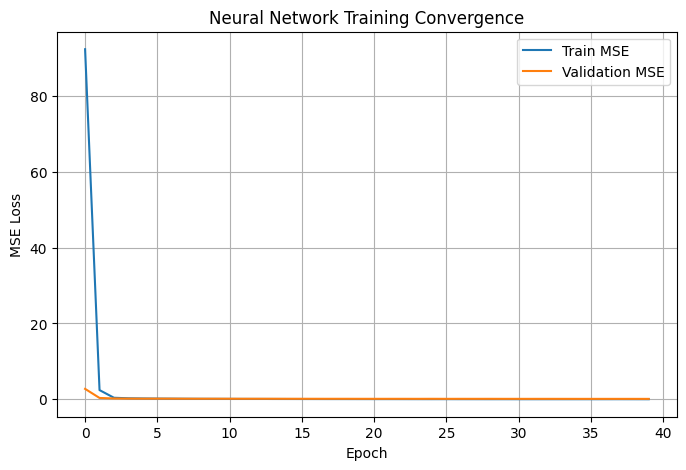

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()
X_train_scaled = X_train_scaled.astype(float)
X_test_scaled  = X_test_scaled.astype(float)

scaler = StandardScaler()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])

X_train_t = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_t = torch.tensor(np.log1p(y_train.values), dtype=torch.float32).view(-1, 1)
X_test_t  = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_t  = torch.tensor(np.log1p(y_test.values), dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train_t.shape[1]

model = RegressionNN(input_dim)

criterion = nn.MSELoss()          # regression loss
optimizer = optim.Adam(
    model.parameters(),
    lr=0.001
)

epochs = 40
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ----- validation loss -----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"- Train MSE: {train_loss:.4f} "
            f"- Val MSE: {val_loss:.4f}"
        )

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Neural Network Training Convergence")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
model.eval()
with torch.no_grad():
    y_pred_log = model(X_test_t).cpu().numpy().ravel()

y_true_log = y_test_t.cpu().numpy().ravel()

log_rmse = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
print(f"Log RMSE: {log_rmse:.5f}")

Log RMSE: 0.31784


In [14]:
# --------------------------------------------------
# Load test data
# --------------------------------------------------
test_df = pd.read_csv("test.csv")

test_df=fill_missing(test_df)
test_df=preprocess_categorical(test_df)

# --------------------------------------------------
# Align with training features
# --------------------------------------------------
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# --------------------------------------------------
# Gradient Boosting Regressor with given parameters
# --------------------------------------------------

gbr_model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.9,
    max_features="sqrt",
    random_state=42
)

# Fit on full training data
gbr_model.fit(X, y)

# Predict on test set
test_pred = gbr_model.predict(test_df)
test_pred = np.clip(test_pred, 0, None)

# Create submission
submission = pd.DataFrame({
    "Id": test_df.index + 1461,
    "SalePrice": test_pred
})

submission.to_csv("submission.csv", index=False)
print("Submission saved as submission.csv")


Submission saved as submission.csv


In [15]:
# --------------------------------------------------
# Load test data
# --------------------------------------------------
test_df = pd.read_csv("test.csv")

test_df = fill_missing(test_df)
test_df = preprocess_categorical(test_df)

# --------------------------------------------------
# Align with training features
# --------------------------------------------------
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# --------------------------------------------------
# Scale numeric features (IMPORTANT: use fitted scaler)
# --------------------------------------------------
test_df_scaled = test_df.copy()
test_df_scaled = test_df_scaled.astype(float)
test_df_scaled[num_cols] = scaler.transform(test_df[num_cols])

X_test_t = torch.tensor(
    test_df_scaled.values,
    dtype=torch.float32
)

model.eval()
with torch.no_grad():
    y_pred_log = model(X_test_t).cpu().numpy().ravel()

y_pred = np.expm1(y_pred_log)   # reverse log1p
y_pred = np.clip(y_pred, 0, None)

submission = pd.DataFrame({
    "Id": test_df.index + 1461,
    "SalePrice": y_pred
})

submission.to_csv("nn_submission.csv", index=False)
print("Submission saved as nn_submission.csv")


Submission saved as nn_submission.csv


In [16]:
import joblib
# --------------------------------------------------
# Gradient Boosting Regressor
# --------------------------------------------------
gbr_model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.9,
    max_features="sqrt",
    random_state=42
)

# Fit on full training data
gbr_model.fit(X, y)

# --------------------------------------------------
# Save model as joblib
# --------------------------------------------------
joblib.dump(gbr_model, "best_model.joblib")
print("Model saved as best_model.joblib")

Model saved as best_model.joblib
